<a href="https://colab.research.google.com/github/Mat11-py/Computer_Vision/blob/main/Actividad_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **phawAI 2025: Clasificación de Imágenes y Redes Neuronales Convolucionales (CNNs)**

proyecto final

En esta clase, usaremos Python como lenguaje de programación y PyTorch como librería para Aprendizaje Profundo. Para una introducción a Python y manipulación de imágenes, puede hacer un repaso completando este cuaderno: [[Python, Numpy y Procesamiento de Imágenes](https://colab.research.google.com/drive/1fI8_ga1ZG1vGPpJUwBMdxnPX6ntrUgrh)]. Para una introducción a PyTorch, pueden completar este cuaderno: [[Python, Pytorch y Plots](https://colab.research.google.com/drive/1UQM4Lzs1sKbmZ7g3D1f98ATTSZM5EyGW?usp=sharing)].

### **0. Preliminares**

En esta sección, revisaremos algunos conceptos básicos de Pytorch para demostrar sus capacidades para la optimización basada en gradientes. Considere, por ejemplo, la siguiente función:

$$ y = 4x + 3z^2$$

Su tarea es encontrar el gradiente $\nabla y = \left(\frac{\partial y}{\partial x}, \frac{\partial y}{\partial z}\right)$ para $x = 2$ y $z = 3$. ¿Cómo lo hacemos? Hay tres formas de hacerlo.

#### **0.1 Derivación Analítica**
Primero, calculemos la fórmula analítica para esta función de la siguiente manera:

$$\frac{\partial y}{\partial x} = 4 \quad\text{ y }\quad \frac{\partial y}{\partial z} = 6z$$

Podemos ver fácilmente que el gradiente en $(x,z) = (2, 3)$ es $\nabla y = (4, 18) $. No es necesario escribir ningún código.

#### **0.2 Aproximación numérica**
El otro método que podemos aplicar se basa en una aproximación numérica utilizando la definición de derivadas. Supongamos que $y = f(x,z)$, entonces las definiciones de derivadas parciales se pueden expresar de la siguiente manera:

$$ \frac{\partial}{\partial x} f(x,z) = \lim_{h_x \to 0} \frac{f(x + h_x, z) - f(x, z)}{h_x}$$

$$ \frac{\partial}{\partial z} f(x,z) = \lim_{h_z \to 0} \frac{f(x, z + h_z) - f(x, z)}{h_z}$$

Podemos calcular esto rápidamente a continuación utilizando algunas funciones básicas de Python.

In [ ]:
def f(x,z):
  return 4 * x + 3 * z * z

def grad_x(f, x, z, h = 0.0001):
  return (f(x + h, z) - f(x, z)) / h

def grad_z(f, x, z, h = 0.0001):
  return (f(x, z + h) - f(x, z)) / h

print(grad_x(f, 2, 3), grad_z(f, 2, 3))

3.9999999999906777 18.000300000053926


Como podemos ver, la aproximación es aproximadamente correcta. Las funciones retornaron el mismo resultado que la derivación analítica.

#### **0.3 Pytorch autograd**

Está bien escribir tus propias derivadas, pero PyTorch ya implementa el cálculo automático de gradientes para todas las operaciones básicas que puedas necesitar y realiza un seguimiento de las operaciones que se aplican cuando se utiliza el  tensor de PyTorch. Siempre que necesites calcular gradientes, puedes llamar a la función backward() en un tensor y aplicará la regla de la cadena para calcular las derivadas de todo el historial de operaciones aplicadas a dicho tensor.

In [ ]:
import torch

# This function assumes, x, z are pytorch tensors but it looks the
# same as the earlier function. We could also restrict the data types in python3.
def f(x: torch.tensor, z: torch.tensor):
  return 4 * x + 3 * z * z

x = torch.tensor(2.0, requires_grad = True)
z = torch.tensor(3.0, requires_grad = True)

# Compute the value of y.
y = f(x,z)

# Compute the gradients for all variables.
y.backward()

# Print the gradients
print(x.grad, z.grad)

tensor(4.) tensor(18.)


Observamos que obtenemos el mismo resultado, excepto que la función de Pytorch es mucho más general. Para empezar, $x$ y $z$ podrían ser vectores en esta implementación sin cambiar nada. No hay necesidad de calcular la derivada analítica y no hay necesidad de tener una función separada para cada derivada parcial. Otra cosa a tener en cuenta, normalmente estaremos optimizando variables que llamaremos $W = [w_1, w_2, ...]$ y usaremos $y$ y $x$ para denotar constantes ya que las usamos para representar los datos de entrenamiento, así que no nos confundamos con esto. Podrás ver esto más claramente en la primera parte de la sección de tareas.

### **1. El Conjunto de Datos SUN**

En 2009, un grupo de investigadores desarrolló SUN397, una base de datos de imágenes que debía cubrir tantas categorías de imágenes de "escenas" como fuera posible (consulte más información [aquí en Tensorflow](https://www.tensorflow.org/datasets/catalog/sun397) o en [Pytorch](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.SUN397.html)). El conjunto de datos tiene al menos 100 imágenes para cada una de las 397 categorías. El conjunto de datos completo cabe en un archivo tar de 39 GB.

#### **1.1 Descargando los Datos**
Para esta tarea, creamos un subconjunto de datos que contiene solo 20 categorías, y redimensionamos previamente las imágenes para que su tamaño más largo sea 256 píxeles -- y también restringimos cada categoría para que tenga exactamente 50 imágenes.

In [ ]:
# This command downloads the files with the prepackaged contents.
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
!tar xf SUN20-train-sm.tar.gz
!tar xf SUN20-val.tar.gz

--2025-09-03 13:28:41--  http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 301 Moved permanently
Location: https://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz [following]
--2025-09-03 13:28:41--  https://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39744791 (38M) [application/x-gzip]
Saving to: ‘SUN20-train-sm.tar.gz’

SUN20-train-sm.tar. 100%[===================>]  37.90M  5.45MB/s    in 7.1s    

2025-09-03 13:28:49 (5.35 MB/s) - ‘SUN20-train-sm.tar.gz’ saved [39744791/39744791]

--2025-09-03 13:28:49--  http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to ww

#### **1.2 Creación de un cargador de datos personalizado**
En Pytorch, una clase de conjunto de datos debe heredar de `torch.utils.data.Dataset` y debe sobreescribir dos métodos: `__getitem__` y `__len__`. Estos métodos deben devolver un elemento y la cantidad de elementos respectivamente.

In [ ]:
import os, json, pickle, random
import torch.utils.data
from PIL import Image

# Simple implementation of a custom data loading class for our SUN20 dataset.
class SUN20(torch.utils.data.Dataset):

  # Initialize the class e.g. load files, preprocess, etc.
  def __init__(self, split = 'train', transform = None):

    # These are the 20 categories selected.
    self.categories = open('SUN20/' + split + '/ClassName.txt').read().split('\n')[:-1]
    self.categories = sorted(self.categories)
    self.category2index = {category: idx for (idx, category) in enumerate(self.categories)}
    self.transform = transform

    # Compile a list of images and corresponding labels.
    self.imagepaths = []
    self.labels = []
    for category in self.categories:
      category_directory = 'SUN20/' + split + category
      category_imagenames = os.listdir(category_directory)
      self.imagepaths += [os.path.join(category_directory, imagename)
                          for imagename in category_imagenames]
      self.labels += [self.category2index[category]] * len(category_imagenames)

    # Sort imagepaths alphabetically and labels accordingly.
    sorted_pairs = sorted(zip(self.imagepaths, self.labels), key = lambda x: x[0])
    self.imagepaths, self.labels = zip(*sorted_pairs)


  # Return a sample (x, y) as a tuple e.g. (image, label)
  def __getitem__(self, index):
    image = Image.open(self.imagepaths[index]).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, self.labels[index]

  # Return the total number of samples.
  def __len__(self):
    return len(self.imagepaths)


#### **1.3 Usando del cargador de datos personalizado**

Aquí mostramos cómo utilizar el conjunto de datos SUN20 mediante nuestra clase de cargador de datos, y mostramos cómo explorar imágenes en este conjunto de datos. Antes de comenzar cualquier proyecto, siempre es útil escribir código para explorar el conjunto de datos y visualizarlos.

This dataset has 1000 training images
Image 7 is a /a/arch
Image size is 385x256


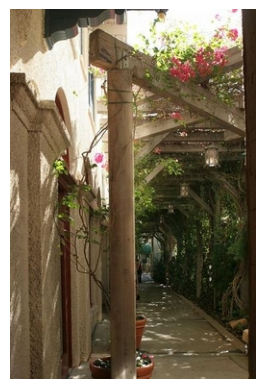

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

trainset = SUN20(split = 'train')
image_index = 7  # Feel free to change this.

# 1. Datasets need to implement the __len__ method for this to work.
print('This dataset has {0} training images'.format(len(trainset)))

# 2. Datasets need to implement the  __getitem__ method for this to work.
img, label = trainset[image_index]  # Returns image and label.

print('Image {0} is a {1}'.format(image_index, trainset.categories[label]))
print('Image size is {0}x{1}'.format(img.height, img.width))

# Show the image.
plt.figure();plt.imshow(img);
plt.grid(False); plt.axis('off'); plt.show()

#### **1.4 Explorando imágenes en SUN20**

***Estadísticas del conjunto de datos:*** El objetivo de esta sección es aprender a usar el cargador de datos y manipulaciones básicas de imágenes con Python/Pytorch. Escribe el código a continuación para imprimir la cantidad de imágenes tomadas en modo vertical (alto mayor que ancho) en el conjunto de datos para cada categoría y ordenadas en orden decreciente por este número. Incluyo los números que obtuve. Para obtener el punto completo, tu código debe tener el mismo resultado que se muestra a continuación y demorar menos de 3.5 segundos en promedio en ejecutarse.

**Desafío**: Intente hacerlo usando la mínima cantidad de bucles posibles, en el menor tiempo de ejecución posible y con la menor cantidad de líneas de código, también haz que tu código sea legible y fácil de entender.

In [ ]:
trainset = SUN20(split = 'train')
valset = SUN20(split = 'val')

In [ ]:
from collections import defaultdict
import time
from PIL import Image

start_time = time.time()

# Diccionario para contar imágenes verticales por categoría
vertical_counts = defaultdict(int)

# Recorremos todas las imágenes una sola vez
for path, label in zip(trainset.imagepaths, trainset.labels):
    with Image.open(path) as img:
        if img.height > img.width:
            category = trainset.categories[label]
            vertical_counts[category] += 1

# Ordenamos el resultado en orden decreciente por cantidad
sorted_vertical_counts = sorted(vertical_counts.items(), key=lambda x: x[1], reverse=True)

# Imprimimos el resultado
for category, count in sorted_vertical_counts:
    print(f'{category}: {count}')

print(f"\nTiempo de ejecución: {time.time() - start_time:.2f} segundos")


/s/shower: 42
/t/tower: 40
/s/sauna: 25
/s/skyscraper: 23
/a/arch: 20
/l/lighthouse: 20
/t/tree_house: 19
/b/bathroom: 18
/d/dentists_office: 9
/v/volcano: 8
/h/hot_spring: 6
/j/jacuzzi/indoor: 6
/m/mansion: 6
/l/laundromat: 5
/l/library/indoor: 5
/m/marsh: 3
/m/mountain: 3
/b/butte: 2
/l/lecture_room: 1

Tiempo de ejecución: 0.44 segundos


**Nota:** Este es solo un ejercicio de calentamiento, pero es importante hacerlo antes de comenzar cualquier proyecto: Explorar el conjunto de datos. Claramente, este conjunto de datos no es ideal, ya que algunas categorías tienen muchas más imágenes para entrenamiento que otras. Sin embargo, el conjunto de validación tiene una cantidad igual de imágenes. Esto es algo que debemos tener en cuenta.

***Visualización:*** El objetivo de esta sección es que visualices algunas de las imágenes del conjunto de datos de entrenamiento y te hagas una idea de lo desafiante que es la tarea requerida. Muestra algunas imágenes organizadas en una cuadrícula de 4x12 para una categoría determinada, de modo que se puedan mostrar como una sola imagen, como en el ejemplo a continuación para `rascacielos`. Incluye en tu tarea el resultado para la categoría `pantano`. Nota: Probablemente necesites recortar y cambiar el tamaño de las imágenes para unirlas. **[1pt]**

In [ ]:
print(trainset.categories)

['/a/arch', '/b/bathroom', '/b/butte', '/d/dentists_office', '/h/hot_spring', '/j/jacuzzi/indoor', '/l/laundromat', '/l/lecture_room', '/l/library/indoor', '/l/lighthouse', '/l/living_room', '/m/mansion', '/m/marsh', '/m/mountain', '/s/sauna', '/s/shower', '/s/skyscraper', '/t/tower', '/t/tree_house', '/v/volcano']


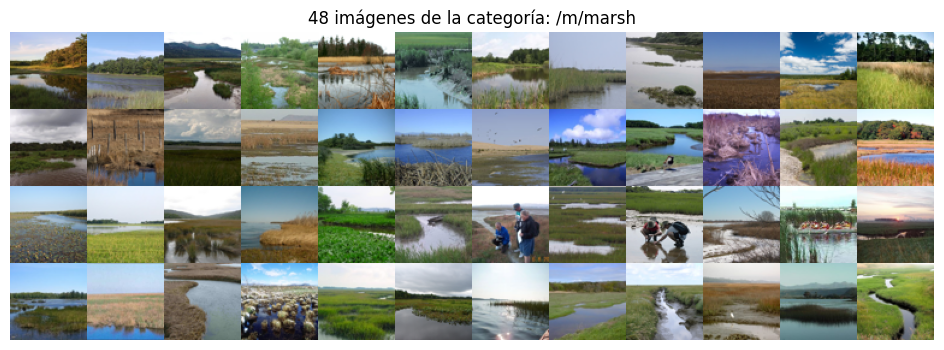

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

category_name = '/m/marsh'
rows, cols = 4, 12
image_size = (64, 64)

category_index = trainset.category2index[category_name]
category_imagepaths = [path for path, label in zip(trainset.imagepaths, trainset.labels) if label == category_index]
selected_paths = category_imagepaths[:rows * cols]

processed_images = []
for path in selected_paths:
    img = Image.open(path).convert('RGB')
    min_dim = min(img.size)
    crop = transforms.CenterCrop(min_dim)(img)
    resized = crop.resize(image_size)
    processed_images.append(resized)

grid_image = Image.new('RGB', (cols * image_size[0], rows * image_size[1]))

for idx, img in enumerate(processed_images):
    row = idx // cols
    col = idx % cols
    grid_image.paste(img, (col * image_size[0], row * image_size[1]))

plt.figure(figsize=(12, 4))
plt.imshow(grid_image)
plt.title(f'48 imágenes de la categoría: {category_name}')
plt.axis('off')
plt.show()


In [ ]:
# Your code goes here.

**Note:** Hopefully after visualzing the category `butte` you can visualize what this word really means.

### **2. Clasificadores Lineales**
En esta sección, exploraremos cómo definir y entrenar clasificadores lineales para clasificar imágenes en una de las 20 categorías del conjunto de datos SUN20 que acabamos de definir en la sección anterior.

#### **2.1 Definiendo un clasificar lineal**


Ahora podemos construir un clasificador lineal binario y entrenarlo usando SGD. Para este propósito, nos basaremos en la biblioteca Pytorch, pero podríamos usar cualquiera. No necesitamos calcular gradientes analíticamente, ya que Pytorch realiza un seguimiento de las operaciones. Usando Pytorch, las clases deben heredar de `torch.nn.Module` y la función que toma entradas y produce valores predichos debe implementarse en su función `forward`.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Let's define a linear classifier (One layer neural network).
# Pytorch supports batches so this model already can receive a set of inputs
# and not just one vector at a time. e.g. inputs of size batch_size x input_size.
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        # The classifier will be binary either positive or negative review.
        # So we only need one output variable in the linear layer.
        self.linear = nn.Linear(input_size, num_classes)

    # Apply the linear operation and the softmax operation.
    def forward(self, encoded_input):
        return self.linear(encoded_input)

# Create an instance of this linear classifier.
model = LinearClassifier(32 * 32 * 3, len(trainset.categories))

# Create a dummy row vector filled with random values.
dummy_vector = torch.rand(1, 32 * 32 * 3)

# Compute some predictions using the model.
predictions = model(dummy_vector).softmax(dim = 1)

# Show predictions from this randomly initialized model.
for i in range(0, len(trainset.categories)):
  score = predictions[0, i].item()
  category = trainset.categories[i]
  print('P("{0}") = {1:.2f}'.format(category, score))

P("/a/arch") = 0.07
P("/b/bathroom") = 0.10
P("/b/butte") = 0.03
P("/d/dentists_office") = 0.02
P("/h/hot_spring") = 0.05
P("/j/jacuzzi/indoor") = 0.04
P("/l/laundromat") = 0.04
P("/l/lecture_room") = 0.05
P("/l/library/indoor") = 0.05
P("/l/lighthouse") = 0.06
P("/l/living_room") = 0.09
P("/m/mansion") = 0.03
P("/m/marsh") = 0.04
P("/m/mountain") = 0.07
P("/s/sauna") = 0.04
P("/s/shower") = 0.03
P("/s/skyscraper") = 0.04
P("/t/tower") = 0.07
P("/t/tree_house") = 0.06
P("/v/volcano") = 0.03


#### **2.2 Bucle de Stochastic Gradient Descent (SGD)**

Ahora procedemos a entrenar el clasificador que definimos en la sección anterior utilizando Stochastic Gradient Descent (SGD) en minilotes (mini-batch). Revise el código de la siguiente sección con especial atención. Cada línea de código es importante.

In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# Defining as global the device to use (by default CPU).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(batch_size,
                n_epochs,
                learningRate,
                model,
                cost_function,
                optimizer,
                scheduler,
                train_loader,
                val_loader):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  best_accuracy = 0
  liveloss = PlotLosses()

  # Main for loop of SGD.
  for epoch in range(0, n_epochs):
    logs = {}

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in training mode.
    model.train()

    # Sample a batch on each iteration.
    for (batch_id, (xb, yb)) in enumerate(train_loader):
      model.zero_grad()

      # Move (x,y) data to GPU (if so desired).
      xb = xb.to(device)
      yb = yb.to(device)

      # Compute predictions.
      predicted = model(xb)
      # print(xb.shape, yb.shape, predicted.shape)

      # Compute loss.
      loss = cost_function(predicted, yb)
      cumulative_loss += loss.item()

      # Count how many correct in batch.
      predicted_ = predicted.detach().softmax(dim = 1)
      max_vals, max_ids = predicted_.max(dim = 1)
      correct += (max_ids == yb).sum().cpu().item()
      n_samples += xb.size(0)

      # Compute gradients (autograd).
      loss.backward()

      # Run one basic training step of SGD.
      optimizer.step()
      # This does basically the following operation.
      # for param in model.parameters():
      #    param.data -= learningRate * param.grad.data

      # Keep track of loss and accuracy for the plot.
      n_batches = 1 + batch_id
      logs['loss'] = cumulative_loss / n_batches
      logs['accuracy'] = correct / n_samples

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in evaluation mode.
    model.eval()

    # No need to keep track of gradients for this part.
    with torch.no_grad():
      # Run the model on the validation set to keep track of accuracy there.
      for (batch_id, (xb, yb)) in enumerate(val_loader):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)

        # Compute predictions.
        predicted = model(xb)

        # Compute loss.
        loss = cost_function(predicted, yb)
        cumulative_loss += loss.item()

        # Count how many correct in batch.
        predicted_ = predicted.detach().softmax(dim = 1)
        max_vals, max_ids = predicted_.max(dim = 1)
        correct += (max_ids == yb).sum().cpu().item()
        n_samples += xb.size(0)

        # Keep track of loss and accuracy for the plot.
        n_batches = 1 + batch_id
        logs['val_loss'] = cumulative_loss / n_batches
        logs['val_accuracy'] = correct / n_samples

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()

    # What is this for? Please look it up.
    if scheduler != -1:
        scheduler.step()

  # Load the model parameters for the one that achieved the best val accuracy.
  # model.load_state_dict(torch.load('best_model_so_far.pth'))

#### **2.3 Training of our Linear Classifier**

Ejecuta el código para entrenar nuestro modelo LinearClassifier  utilizando data loaders para la carga y ensamblaje por lotes. Además, observa cuidadosamente el uso de `torchvision.transforms`

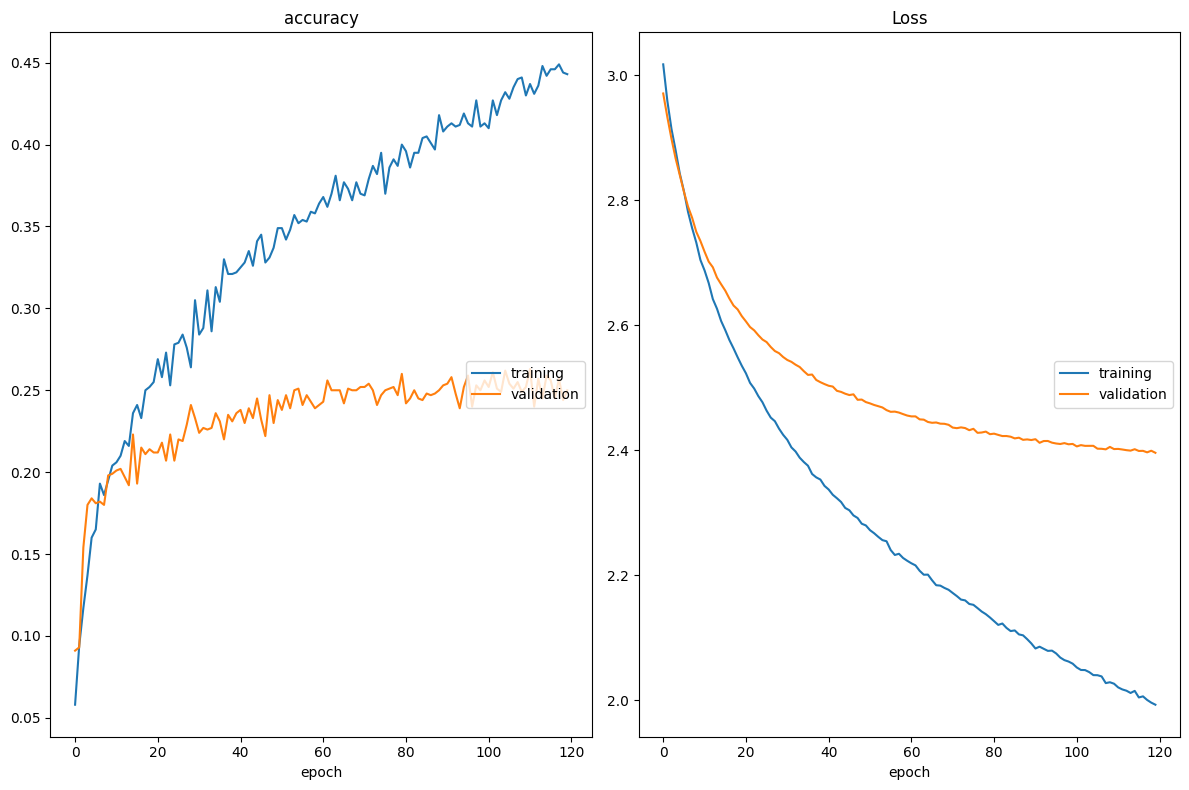

accuracy
	training         	 (min:    0.058, max:    0.449, cur:    0.443)
	validation       	 (min:    0.091, max:    0.263, cur:    0.250)
Loss
	training         	 (min:    1.993, max:    3.018, cur:    1.993)
	validation       	 (min:    2.396, max:    2.971, cur:    2.396)


In [ ]:
import torch.optim
import torchvision.transforms as transforms

batch_size = 16
n_epochs = 120
learningRate = 1e-3

# torch.nn.CrossEntropyLoss applies the softmax to the predictions by the model.
cost_function = torch.nn.CrossEntropyLoss()
model = LinearClassifier(32 * 32 * 3, len(trainset.categories))

# Basic SGD Optimizer.
optimizer = torch.optim.SGD(model.parameters(), lr = learningRate)

class Flatten(object):
  def __call__(self, input_tensor):
    return input_tensor.view(32 * 32 * 3)

transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                Flatten()])

trainset = SUN20(split = 'train', transform = transform)
valset = SUN20(split = 'val', transform = transform)

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset,
                                         batch_size = batch_size,
                                         shuffle = False)

train_model(batch_size, n_epochs, learningRate,
            model, cost_function, optimizer, -1,
            train_loader, val_loader);

Se puede ver que este modelo realmente está aprendiendo la tarea, la precisión sigue aumentando y la pérdida tanto en los datos de entrenamiento como en los datos de validación sigue disminuyendo. A pesar de ser el clasificador lineal más simple, funciona en cierta medida: alcanza una precisión de aproximadamente el 26 % y parece que el entrenamiento comenzó a converger. ¿Qué efecto tendría un clasificador aleatorio en está tarea?

### **3. Redes Neuronales Convolucionales**

El clasificador que utilizamos en la sección anterior no es muy bueno. En esta sección definiremos un nuevo clasificador que utiliza en su lugar una red neuronal convolucional. Aquí proporcionamos una definición para dicha red neuronal. Esta red está diseñada para recibir imágenes como entrada con una resolución de 48x48.

In [ ]:
class ConvnetClassifier(torch.nn.Module):
    def __init__(self):
        super(ConvnetClassifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = (5, 5))
        self.conv2 = torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3))
        self.linear1 = torch.nn.Linear(in_features = 128 * 10 * 10, out_features = 256)
        self.linear2 = torch.nn.Linear(in_features = 256, out_features = 20)

    def forward(self, x):
        # First conv layer + maxpool2d + relu.
        x = self.conv1(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Second conv layer + maxpool2d + relu.
        x = self.conv2(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        x = torch.nn.functional.relu(x)

        # Vectorize except along the batch dimension.
        # You can always print here x.shape to see what it looks like.
        x = x.view(x.size(0), -1)

        # Pass through linear layers.
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        x = self.linear2(x)
        return x

# Test your model!
# Create dummy batch with 24 samples, where each is an image of size 3x48x48.
dummy_batch = torch.zeros(24, 3, 48, 48)
my_model = ConvnetClassifier()
predictions = my_model(dummy_batch)

# Seems like working to me.
print(dummy_batch.shape, predictions.shape)

torch.Size([24, 3, 48, 48]) torch.Size([24, 20])


## **Preguntas**

#### **A.0 Preliminares**
Ajuste de curvas con pytorch para una función simple. Dados los siguientes puntos de datos, entrene cuatro parámetros para que se pueda ajustar una función polinómica a ellos. Escriba el código en Pytorch usando pytorch autograd para que pueda encontrar coeficientes para la siguiente función de modo que se ajusten a los puntos de datos dados. Encuentre $w_1$, $w_2$, $w_3$ y $b$ de modo que:


$$y = f(x) = w_1 x^3 + w_2 x^2 + w_3 x + b$$


Encuentre los valores de $w$ de modo que $L(w_1, w_2, w_3, b) = \sum_i (y_i - f(x_i))^2$ se minimice. Imprima los valores que obtuvo para estos parámetros y también trace algunas predicciones para valores de $x$ de entrada aleatorios entre 0 y 1 y trace sobre los puntos originales. A continuación se proporciona algo de código.

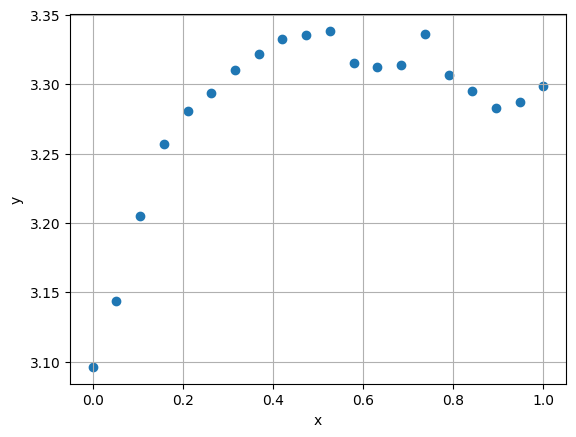

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
data = np.array([[0., 3.09621176],
        [0.05263158, 3.1439874 ],
        [0.10526316, 3.20488064],
        [0.15789474, 3.25677788],
        [0.21052632, 3.28074662],
        [0.26315789, 3.29389597],
        [0.31578947, 3.31029492],
        [0.36842105, 3.32189618],
        [0.42105263, 3.33234714],
        [0.47368421, 3.33545394],
        [0.52631579, 3.33849267],
        [0.57894737, 3.31554205],
        [0.63157895, 3.31275422],
        [0.68421053, 3.31412129],
        [0.73684211, 3.33618809],
        [0.78947368, 3.30658756],
        [0.84210526, 3.29551117],
        [0.89473684, 3.28314684],
        [0.94736842, 3.28691712],
        [1., 3.29905823]])
plt.scatter(data[:,0], data[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.grid('on')
plt.show()

Proporcionamos aquí un código de inicio, complete el código utilizando su conocimiento de Pytorch. Adicionar su imágen generada [aquí](https://docs.google.com/spreadsheets/d/1whvZyvPs8v0YIoK1SX9XIvKADg9E7hbLNUFIxmO-ULM/edit?usp=sharing).

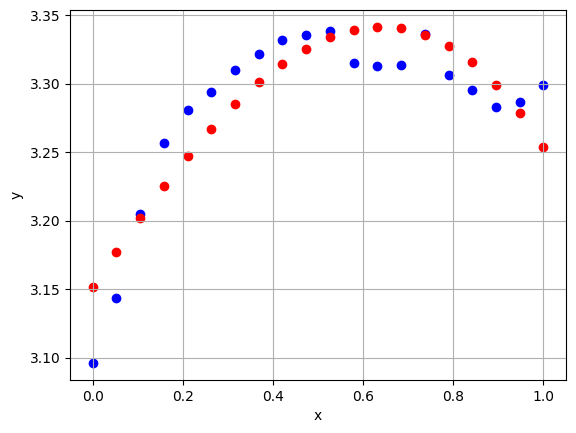

In [ ]:
# Let's define the model function requested.
def f(w_1, w_2, w_3, b, x):
  return w_1 * x ** 3 + w_2 * x ** 2 + w_3 * x + b

# Let's define the loss function requested.
def L(w_1, w_2, w_3, b, y, ypred):
  return torch.sum((y - ypred).pow(2))

# Define the four parameters and start them with some random value.
w_1 = torch.tensor(0.001, requires_grad = True)
w_2 = torch.tensor(0.001, requires_grad = True)
w_3 = torch.tensor(0.001, requires_grad = True)
b = torch.tensor(0.001, requires_grad = True)

# Train data as pytorch tensors.
xs = torch.tensor(data[:, 0])
ys = torch.tensor(data[:, 1])


# Now find w_1, w_2, w_3, and b.
######################

# Número de épocas y tasa de aprendizaje
epochs = 1000
lr = 0.01

for epoch in range(epochs):
    y_pred = f(w_1, w_2, w_3, b, xs)
    loss = L(w_1, w_2, w_3, b, ys, y_pred)

    # Retropropagación
    loss.backward()

    # Actualización de parámetros usando gradiente descendente
    with torch.no_grad():
        w_1 -= lr * w_1.grad
        w_2 -= lr * w_2.grad
        w_3 -= lr * w_3.grad
        b -= lr * b.grad

    # Limpiar gradientes antes del siguiente paso
    w_1.grad.zero_()
    w_2.grad.zero_()
    w_3.grad.zero_()
    b.grad.zero_()

#####################

#print('w1:', w_1.item(), 'w2:', w_2.item(), 'w3:', w_3.item(), 'b:', b.i


# Plot some sample points using your function with the found parameters.
xx = torch.tensor(np.linspace(0, 1, num=20))
yy = f(w_1, w_2, w_3, b, xx)
# Plot the original data in blue.
plt.scatter(data[:,0], data[:,1], c = 'blue')
# Plot new points by sampling from your function f(w1, w2, w3, b)
plt.scatter(xx.detach().numpy(), yy.detach().numpy(), c = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.grid('on')
plt.show()

#### **A.1 Entrenando la red neuronal convolucional de la Sección 3**
En la sección 3, proporcionamos una red neuronal convolucional simple, pero no muestra cómo entrenarla. Utilice el espacio a continuación para escribir el código para entrenar la red neuronal. Siéntase libre de reutilizar el código de las secciones 2 y 3 de esta tarea. La parte más importante es configurar los datos de manera adecuada y elegir los hiperparámetros correctos, como la tasa de aprendizaje, las épocas, el tamaño del lote(batch_size), las opciones de optimizador, etc. Vea el resultado de muestra a continuación -- se espera que logre aproximadamente la misma precisión de validación para obtener la puntuación completa en esta parte. **Nota:** Tenga en cuenta que para obtener puntos, su resultado debe estar en el cuaderno; proporcionar solo el código no le otorga ningún punto.

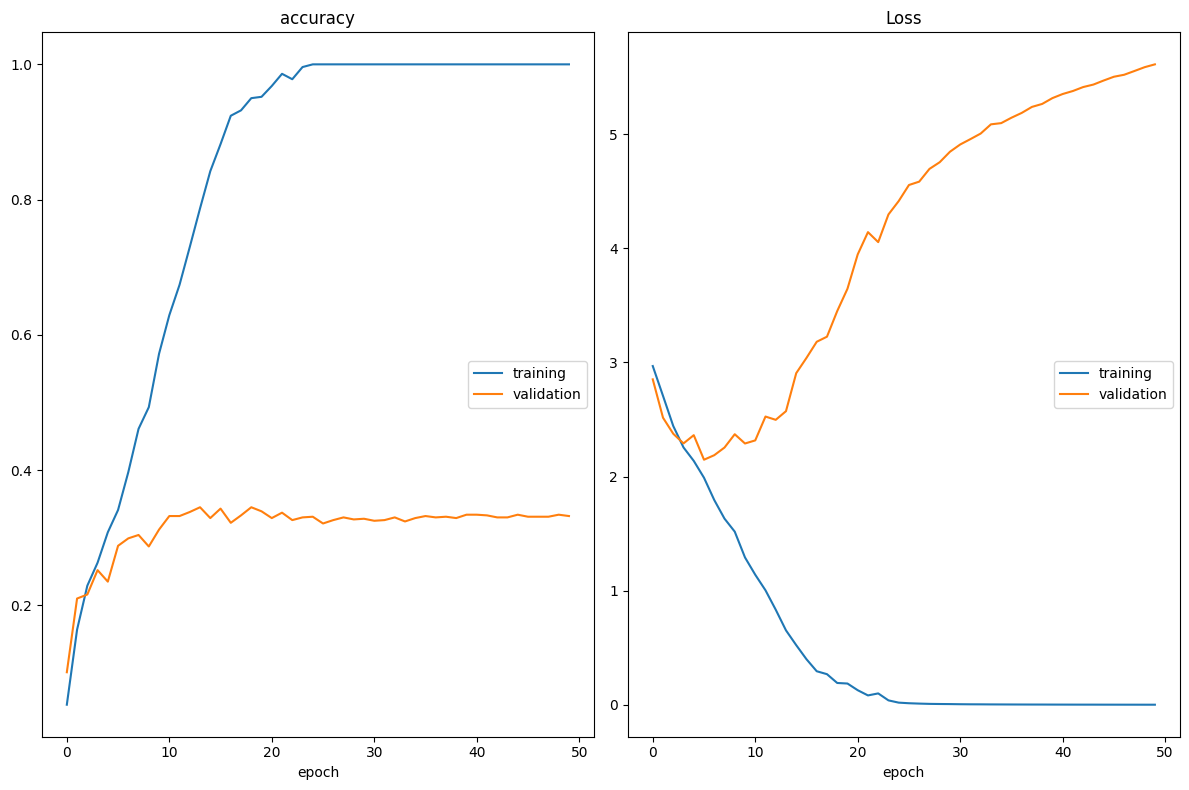

accuracy
	training         	 (min:    0.053, max:    1.000, cur:    1.000)
	validation       	 (min:    0.101, max:    0.345, cur:    0.332)
Loss
	training         	 (min:    0.001, max:    2.968, cur:    0.001)
	validation       	 (min:    2.148, max:    5.611, cur:    5.611)


In [ ]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform_cnn = transforms.Compose([
    transforms.Resize((48, 48)),  # Tamaño esperado por la CNN
    transforms.ToTensor()
])


trainset_cnn = SUN20(split='train', transform=transform_cnn)
valset_cnn = SUN20(split='val', transform=transform_cnn)


batch_size = 32
train_loader_cnn = torch.utils.data.DataLoader(trainset_cnn,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=2,
                                               pin_memory=True)
val_loader_cnn = torch.utils.data.DataLoader(valset_cnn,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=2,
                                             pin_memory=True)

# 5. Instanciar modelo, función de pérdida, optimizador
model_cnn = ConvnetClassifier().to(device)
cost_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)  # Adam para mejor convergencia

# 6. Entrenar la CNN usando tu función train_model
n_epochs = 50

train_model(batch_size=batch_size,
            n_epochs=n_epochs,
            learningRate=1e-3,
            model=model_cnn,
            cost_function=cost_function,
            optimizer=optimizer,
            scheduler=-1,  # sin scheduler por ahora
            train_loader=train_loader_cnn,
            val_loader=val_loader_cnn)


In [ ]:
# Your code goes here.

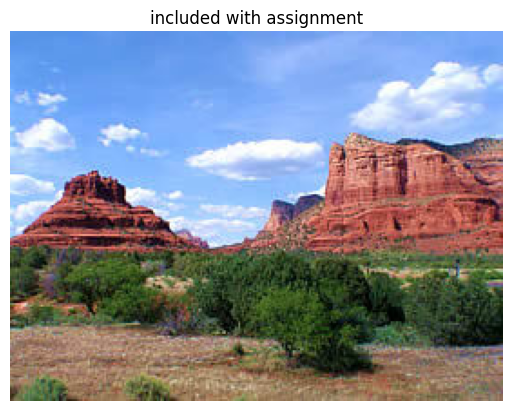

P("/a/arch") = 0.05
P("/b/bathroom") = 0.00
P("/b/butte") = 0.38
P("/d/dentists_office") = 0.00
P("/h/hot_spring") = 0.02
P("/j/jacuzzi/indoor") = 0.00
P("/l/laundromat") = 0.01
P("/l/lecture_room") = 0.02
P("/l/library/indoor") = 0.01
P("/l/lighthouse") = 0.10
P("/l/living_room") = 0.00
P("/m/mansion") = 0.13
P("/m/marsh") = 0.08
P("/m/mountain") = 0.07
P("/s/sauna") = 0.00
P("/s/shower") = 0.00
P("/s/skyscraper") = 0.04
P("/t/tower") = 0.04
P("/t/tree_house") = 0.01
P("/v/volcano") = 0.04


In [ ]:
# Including an example prediction just for your reference to see the model is really working.

import matplotlib.pyplot as plt

input_image_id = 113

# Load the validation set in case not loaded.
valset = SUN20(split = 'val')

# Sample
x,y = valset[input_image_id]

# Process input and add a dummy batch dimension.
xp = transform(x)[None, :].to(device)

predictions = model(xp).softmax(dim = 1)

plt.figure();plt.title("included with assignment");plt.imshow(x);plt.axis(False);plt.show();

# Show predictions from this model.
for i in range(0, len(trainset.categories)):
  score = predictions[0, i].item()
  category = trainset.categories[i]
  print('P("{0}") = {1:.2f}'.format(category, score))


#### **A.2 Mostrar resultados del modelo entrenado previamente**
Muestre los resultados del modelo entrenado en la sección anterior (sec. A.1) mostrando las 20 imágenes principales del conjunto de validación que el modelo predice como `butte`. Muestre los puntajes predichos para cada uno de ellos de alguna manera y coloque un recuadro verde alrededor de las imágenes que efectivamente son `butte` y un recuadro rojo alrededor de las imágenes cuya etiqueta verdadera no es `butte` como se muestra a continuación. Usé la clase ImageDraw de la biblioteca Pillow para dibujar un rectángulo y dibujar algo de texto en las imágenes.

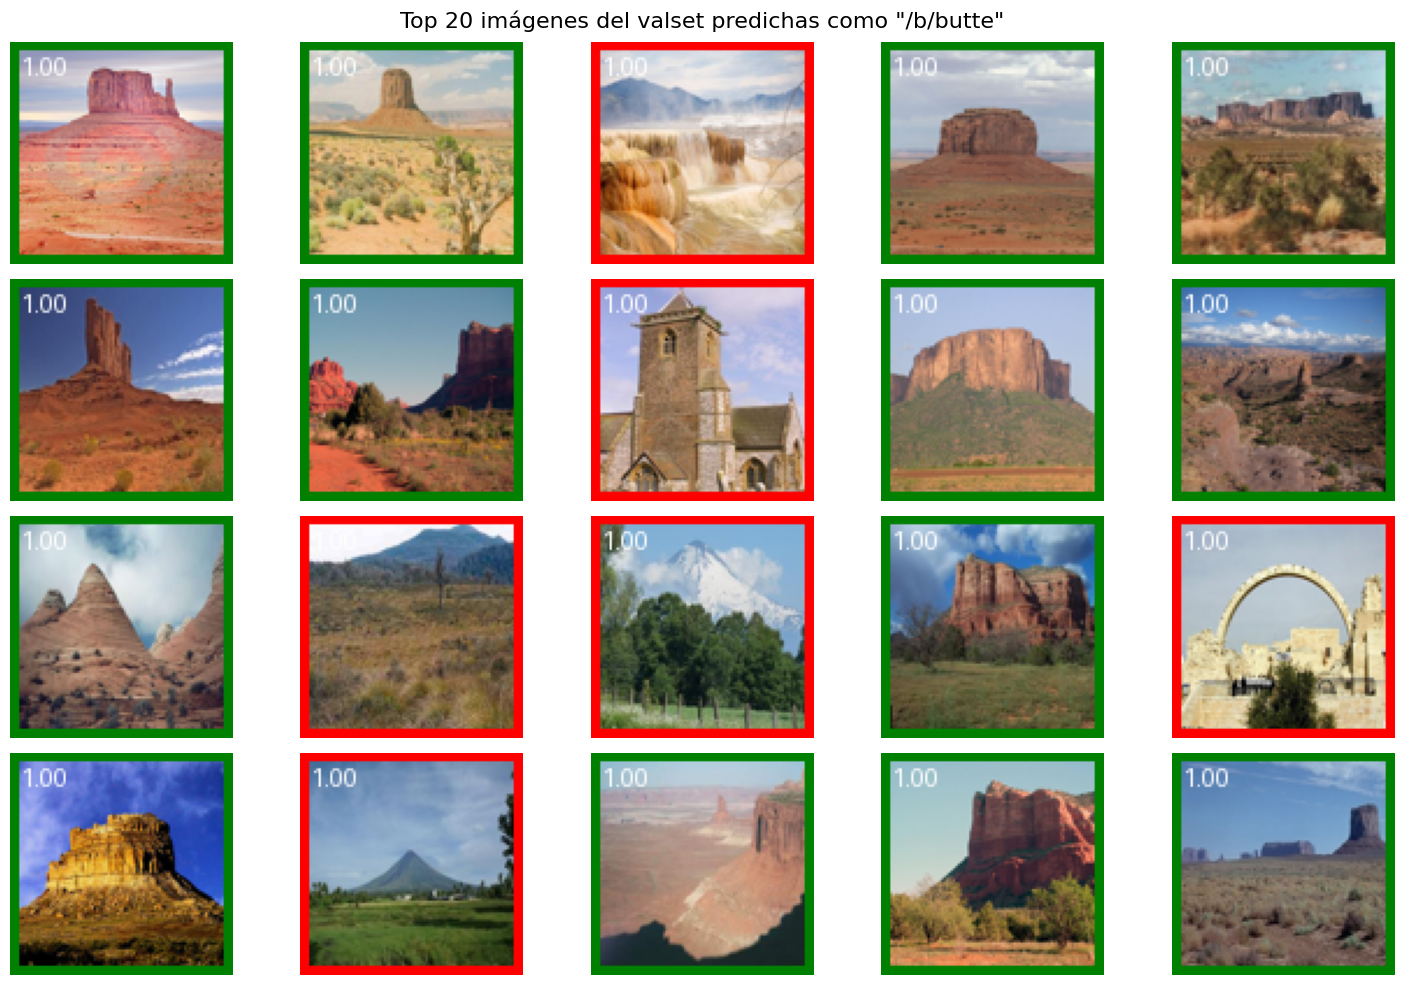

In [ ]:
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt


model_cnn.eval()


valset = SUN20(split='val', transform=transform_cnn)

valset_vis = SUN20(split='val', transform=None)

# Índice de la clase "butte"
target_category = '/b/butte'
target_index = trainset.category2index[target_category]

# Lista para almacenar: (score_butte, image_id, true_label, original_PIL_image)
predicted_scores = []

for i in range(len(valset)):
    # Obtener imagen original (PIL) para mostrar
    img_pil, _ = valset_vis[i]

    # Obtener imagen transformada + etiqueta real
    _, label = valset[i]
    input_tensor = transform_cnn(img_pil)[None, :].to(device)

    # Obtener score de predicción para la clase "butte"
    with torch.no_grad():
        pred = model_cnn(input_tensor).softmax(dim=1)
    score = pred[0, target_index].item()

    # Guardar todo para después
    predicted_scores.append((score, i, label, img_pil))

# Ordenar por mayor score y tomar top 20
top_20 = sorted(predicted_scores, key=lambda x: x[0], reverse=True)[:20]

# Visualización en grid
n_rows, n_cols = 4, 5
image_size = (96, 96)
font = ImageFont.load_default()

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for idx, (score, img_id, true_label, img_pil) in enumerate(top_20):
    row, col = divmod(idx, n_cols)

    # Redimensionar imagen
    img_resized = img_pil.resize(image_size)
    draw = ImageDraw.Draw(img_resized)

    # Colores del marco
    if true_label == target_index:
        border_color = "green"
    else:
        border_color = "red"

    # Dibujar borde
    thickness = 4
    for t in range(thickness):
        draw.rectangle(
            [t, t, image_size[0] - t - 1, image_size[1] - t - 1],
            outline=border_color
        )

    # Dibujar el score en la esquina superior izquierda
    draw.text((5, 5), f"{score:.2f}", fill="white", font=font)

    # Mostrar en la cuadrícula
    axs[row, col].imshow(img_resized)
    axs[row, col].axis('off')

plt.suptitle(f'Top 20 imágenes del valset predichas como "{target_category}"', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Your code goes here.

#### **A.3 Definir y entrenar una mejor red neuronal convolucional**
En la sección 3 y A.1 definimos y entrenamos una red Convolucional (CNN), sin embargo, solo pudimos alcanzar algo más del 30% de precisión. Deberíamos poder hacerlo mejor con una CNN si agregamos quizás más capas, o capas de normalización por lotes (batch normalization), o agregamos algunas formas de regularización como capas de dropout, aumento de datos o elegimos los parámetros de optimización con más cuidado, o consideramos procesar las imágenes a una resolución más alta que 48x48. Diseñe y entrene una CNN que obtenga al menos un 52% de precisión. Este número es ligeramente inferior a la precisión promedio que obtuvieron los estudiantes en una versión anterior de esta clase. Las mejores presentaciones obtuvieron un 60% de precisión o más, una obtuvo un 58% con un tiempo de entrenamiento de menos de 5 minutos. Mi solución a continuación no estaba entre las 10 mejores. Para obtener todos los puntos en esta pregunta, la red tiene que funcionar a la par de lo que se muestra aquí. Además, debe ingresar la siguiente información: Número de parámetros de su red, tiempo de entrenamiento de su red y la máxima precisión de validación lograda [aquí](https://docs.google.com/spreadsheets/d/1whvZyvPs8v0YIoK1SX9XIvKADg9E7hbLNUFIxmO-ULM/edit?usp=sharing) (Pestaña: SUN20-from-scratch-CNN). Por favor, crear una red en lo máximo con 100 millones de parametros.

In [ ]:
import torchvision, torch

class SceneClassifier(torch.nn.Module):
    def __init__(self):
        super(SceneClassifier, self).__init__()
        # Define your layers here.

    def forward(self, x):
        #  Define your forward pass here.
        return x

model = SceneClassifier()

## This is how you can count the number of parameters
## in a neural network in pytorch in a generic way.
#
#count_params = 0
#for param in model.parameters():
#  count_params += param.numel()
#print(count_params)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SceneClassifier(nn.Module):
    def __init__(self):
        super(SceneClassifier, self).__init__()

        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 64x64 -> 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64 -> 32x32
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 -> 16x16
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 -> 8x8
            nn.Dropout(0.4),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 20)  # 20 clases
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [ ]:
model = SceneClassifier()

count_params = sum(p.numel() for p in model.parameters())
print(f"Número total de parámetros: {count_params:,}")


Número total de parámetros: 9,546,580


In [ ]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


In [ ]:
trainset = SUN20(split='train', transform=transform_train)
valset = SUN20(split='val', transform=transform_val)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


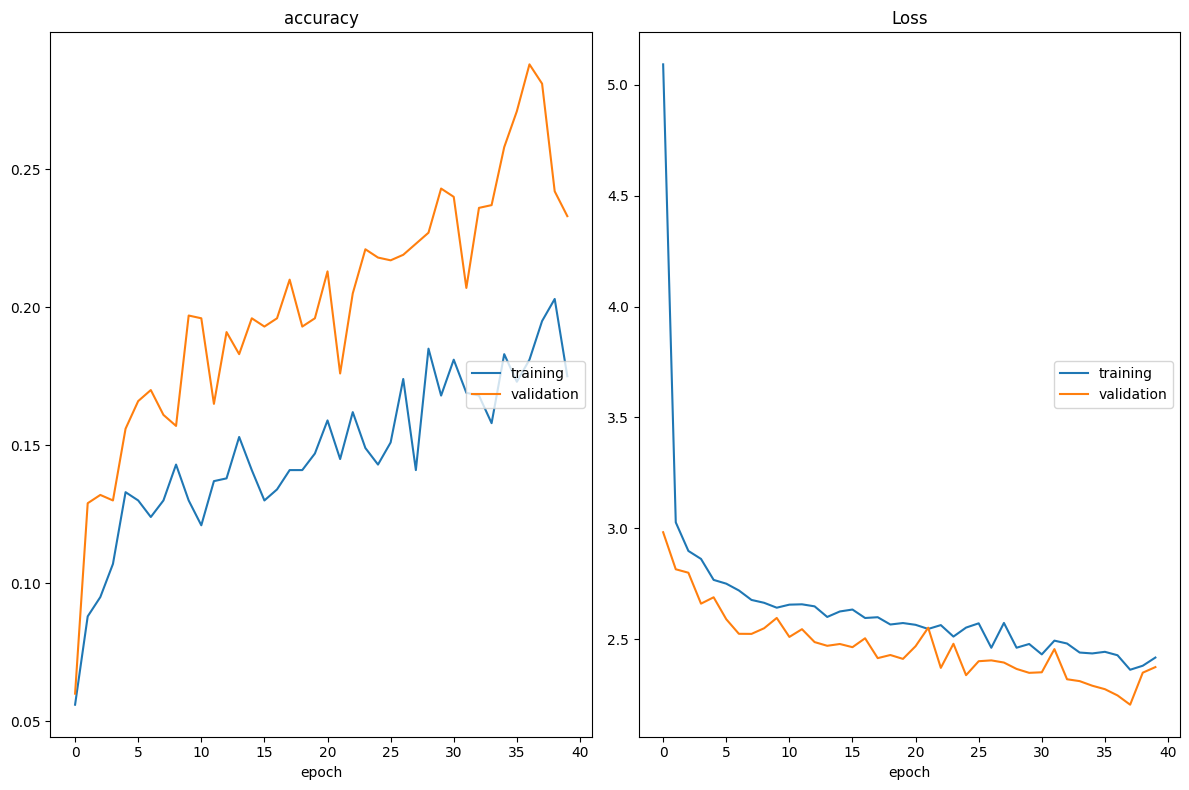

accuracy
	training         	 (min:    0.056, max:    0.203, cur:    0.175)
	validation       	 (min:    0.060, max:    0.288, cur:    0.233)
Loss
	training         	 (min:    2.362, max:    5.092, cur:    2.417)
	validation       	 (min:    2.204, max:    2.982, cur:    2.374)

⏱️ Tiempo de entrenamiento: 5155.10 segundos


In [ ]:
import time
from livelossplot import PlotLosses

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SceneClassifier().to(device)

cost_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

start_time = time.time()

train_model(batch_size=32,
            n_epochs=40,
            learningRate=1e-3,
            model=model,
            cost_function=cost_function,
            optimizer=optimizer,
            scheduler=-1,
            train_loader=train_loader,
            val_loader=val_loader)

end_time = time.time()
training_time = end_time - start_time
print(f"\n⏱️ Tiempo de entrenamiento: {training_time:.2f} segundos")


In [ ]:
# Your code goes here.

In [ ]:
# This is included here just for your reference.

In [ ]:
# Showing here the images in the validation set with the largest predicted scores for /b/butte

#### **A.4 Entrene una red neuronal existente a partir de modelos de Pytorch**

Pytorch contiene una amplia biblioteca de modelos preentrenados, modelos que ya se han entrenado en un conjunto de datos de gran escala, a menudo con millones de imágenes y miles de categorías. Reutilice uno de estos modelos con sus pesos preentrenados y "afine" el modelo para que funcione bien en el conjunto de datos SUN20 reemplazando la última capa con una capa que prediga 20 resultados y ejecute un par de rondas de ajuste hasta lograr un clasificador que funcione con una precisión de aproximadamente el 90 % (lo ideal sería que fuera más). Usé EfficientNet V2 Medium Size para obtener el rendimiento que se muestra a continuación, con un 91,8 % en solo 7 épocas. Ingrese la información de su implementación [aquí](https://docs.google.com/spreadsheets/d/1whvZyvPs8v0YIoK1SX9XIvKADg9E7hbLNUFIxmO-ULM/edit?usp=sharing) (Pestaña: SUN20-pretrained-CNN)

Algunos links de utilidad son:

 * [Aprendizaje Profundo con Imágenes](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
 * [Fine-tunning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
 * [Modelos Pytorch Models](https://pytorch.org/vision/stable/models.html)
 * [Aumento de Datos](https://towardsdatascience.com/image-augmentation-using-python-numpy-opencv-and-skimage-ef027e9898da)
 * [DataSet y DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
 * [Capas Pytorch](https://pytorch.org/docs/stable/nn.html)


In [ ]:
import torchvision.models as models

# Cargar modelo preentrenado
model_ft = models.efficientnet_v2_m(weights='EfficientNet_V2_M_Weights.DEFAULT')

# Cambiar la última capa del clasificador para que prediga 20 clases
num_features = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_features, 20)

# Mover a GPU si está disponible
model_ft = model_ft.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


100%|██████████| 208M/208M [00:02<00:00, 90.3MB/s]


In [ ]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
trainset = SUN20(split='train', transform=transform_train)
valset = SUN20(split='val', transform=transform_val)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_ft.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


In [ ]:
import time
start_time = time.time()

train_model(batch_size=32,
            n_epochs=7,
            learningRate=3e-4,
            model=model_ft,
            cost_function=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            train_loader=train_loader,
            val_loader=val_loader)

end_time = time.time()
print(f"⏱️ Tiempo total de entrenamiento: {end_time - start_time:.2f} segundos")


In [ ]:
val_acc = evaluate_accuracy(model_ft, val_loader)
print(f"✅ Precisión de validación: {val_acc * 100:.2f}%")


In [ ]:
# Include here any necessary code to define and setup your model.

In [ ]:
# Your training code goes here.

In [ ]:
# Test if your model is really working by looking at some of the predictions it makes.

## Clasificación zero-shot con CLIP
 En enero de 2021, OpenAI publicó un artículo de investigación llamado CLIP ( [Contrastive Language-Image Pretraining](https://arxiv.org/abs/2103.00020)) https://openai.com/blog/clip/. Este modelo se entrenó para maximizar el producto escalar entre representaciones vectoriales de texto e imágenes que tienen una correspondencia directa y minimizar su producto escalar cuando no se corresponden. Una propiedad clave de este modelo es que se puede utilizar para construir un clasificador Zero-shot. Dado que el modelo se entrenó con una gran cantidad de imágenes y texto de la web, este modelo conoce muchas categorías de cosas. Su objetivo en esta sección es obtener los mejores resultados utilizando el enfoque ilustrado en esta figura para nuestro problema de clasificación de escenas (SUN20). Ingrese la mejor precisión de clasificación en la tabla [aquí](https://docs.google.com/spreadsheets/d/1whvZyvPs8v0YIoK1SX9XIvKADg9E7hbLNUFIxmO-ULM/edit?usp=sharing) (Pestaña: CLIP). [Para obtener la puntuación completa, obtenga más del 92% de precisión]

 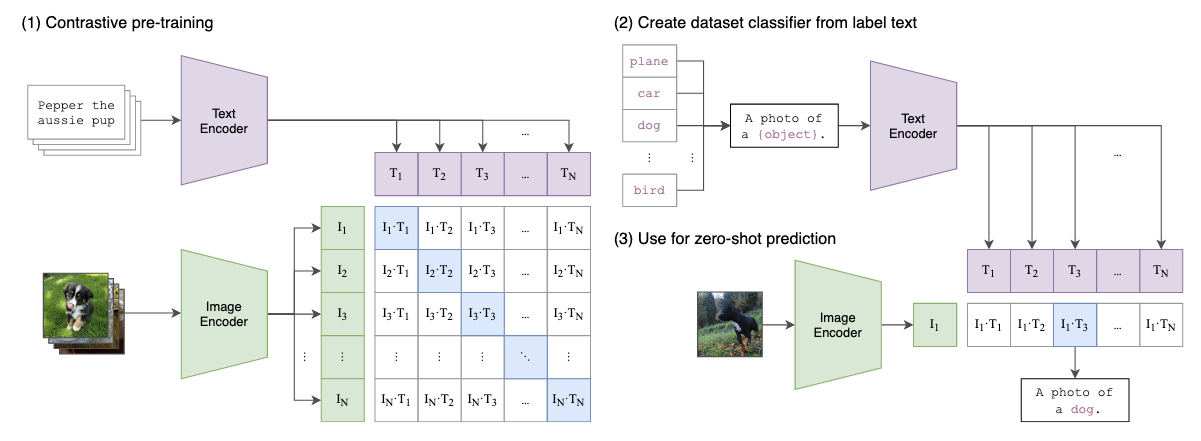

## **IA Generativa**

Genere una imagen como la que se muestra a continuación. Para obtener la máxima puntuación. Debe haber: 1) un búho (an owl), 2) El búho debe estar vistiendo corbata de moño y zapatos (the owl has to be wearing a bowtie and shoes) 3) El fondo debe tener alguna textura similar a un ladrillo (the background must have some brick-like texture), 4) Se debe preservar la calidad estética del resultado (the aesthetic quality of the output should be preserved). Debes incluir la imagen generada en la tabla de clasificación y calcular la puntuación CLIPScore y la puntuación estética de tu imagen. Asegúrate de incluir la imagen utilizando *Insertar -> Imagen -> Insertar imagen en celda* en las hojas de cálculo de Google [[leaderboard](https://docs.google.com/spreadsheets/d/1whvZyvPs8v0YIoK1SX9XIvKADg9E7hbLNUFIxmO-ULM/edit?usp=sharing)].


**Instalando dependencias**

Tal vez necesite reiniciar sesión ( Runtime -> Restart session ) luego de correr esta celda.

In [ ]:
!pip install diffusers mediapy accelerate
!pip install brisque

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
from brisque import BRISQUE

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype = dtype)
pipe = pipe.to(device)
print(pipe)

In [ ]:
def generate_image(prompt: str):
    with torch.autocast("cuda"):
      result = pipe(prompt, num_inference_steps=50, guidance_scale=7.9)
    owl_image = result.images[0]
    display(owl_image)


    # Load CLIP model
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Preprocess inputs
    inputs = processor(text=prompt, images=owl_image, return_tensors="pt", padding=True)

    # Get similarity
    with torch.no_grad():
        outputs = model(**inputs)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds

    # Normalize
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

    # Cosine similarity = CLIPScore
    clip_score = (image_embeds @ text_embeds.T).item()
    print(f"CLIPScore: {clip_score:.4f}")

    obj = BRISQUE(url=False)
    print(f"Puntuación BRISQUE: {obj.score(owl_image)}")

In [ ]:
# Your promt goes here.
promt = ""
generate_image(promt)

In [ ]:
from IPython.display import Image
Image("owl_image.png")

## **Rúbrica**
 1. [Sección A.0] Optimización --> 4 puntos
 1. [Sección A.3] Red Neuronal desde cero, basada en **max_validation_accuracy**
    *  50 < max_validation_accuracy < 55 --> 4 puntos
    *  55 < max_validation_accuracy < 60 --> 5 puntos
    *  max_validation_accuracy > 60 --> 6 puntos
 2. [Sección A.4] Red Neuronal Pre-entrenada, basada en **max_validation_accuracy**
    *  90 <= max_validation_accuracy < 91 --> 1 puntos
    *  91 <= max_validation_accuracy < 92 --> 2 puntos
    *  92 <= max_validation_accuracy < 93 --> 3 puntos
    *  93 <= max_validation_accuracy < 94 --> 4 puntos
    *  max_validation_accuracy >= 95 --> 5 puntos
3. Clasificación zero-shot con CLIP, basada en **max_validation_accuracy**
    *  max_validation_accuracy >= 92 --> 3 puntos
4. IA Generativa, basada en **CLIPScore y Puntuación Estética**

    * CLIPScore >= 0.25 y Puntuación BRISQUE <= 60 --> 1 puntos
    * CLIPScore >= 0.35 y Puntuación BRISQUE <= 30 --> 2 puntos

## **Agradecimientos**
Tarea basada en el curso de [Deep Learning for Vision and Language](https://www.cs.rice.edu/~vo9/deep-vislang/) del Prof. Vicente Ordoñez (Rice University). Traducido y actualizado con pequeñas modificaciones por el Prof. Nils Murrugarra (Univ. of Pittsburgh y Bach. Jose Luis Barba (Universidad Nacional de Trujillo).